# Part 1: How to Explore the GAN Latent Space When Generating Faces (25 pts)

1. Implement SR-GAN on your own using PyTorch. (Ref: https://arxiv.org/abs/1609.04802)

2. Use the ImageNet dataset to run a few epochs to train the model. You may use the script provided here to generate training data: Dataset (https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/srgan/datasets.py). However, there is some issue with this code, hence the drive link for the generated images is shared below. Please use this link to access the dataset for training SRGAN. (https://drive.google.com/drive/folders/13txSH8LU64amnvY0hkxMxMI6F6ssbErG?usp=sharing ) .

Note: you should only use this repo for dataset code and reference. Model and results
(20 pts) + report (5 pts)

In [1]:
import glob
import random
import os
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms


# Configurations

In [2]:
! mkdir trained_model

mkdir: trained_model: File exists


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps"

LOAD_MODEL = True
SAVE_MODEL = True

CHECKPOINT_GEN = "trained_model/gen.pth.tar"
CHECKPOINT_DISC = "trained_model/disc.pth.tar"

LEARNING_RATE = 1e-4
NUM_EPOCHS = 32
BATCH_SIZE = 16

HIGH_RES = 96
LOW_RES = HIGH_RES // 4
IMG_CHANNELS = 3


base_data_path = "./SRGAN_Data/"

# Data Loading And Transformation

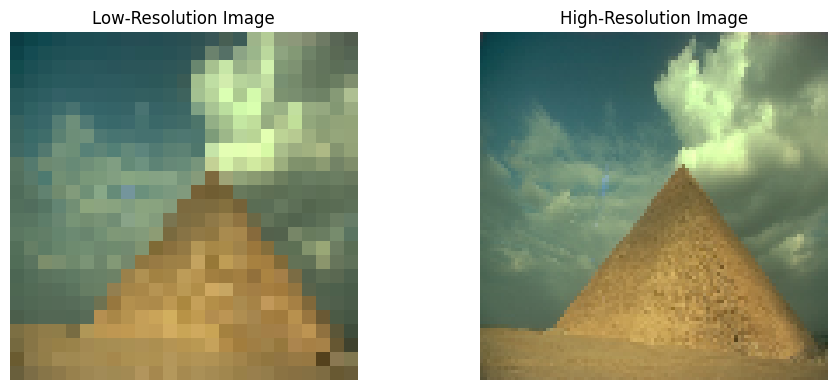

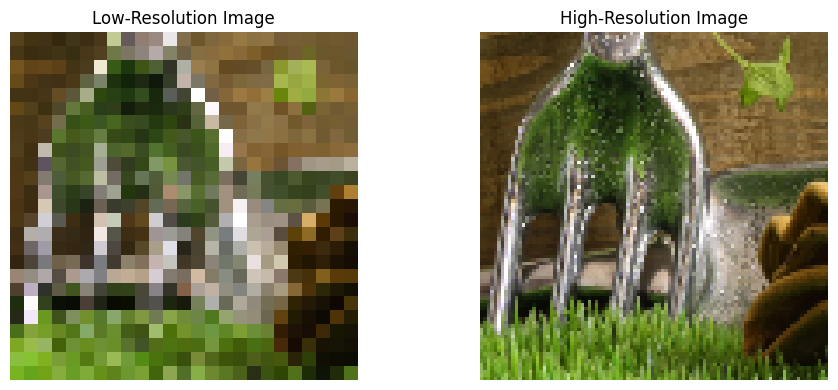

In [4]:
import matplotlib.pyplot as plt

def show_samples(data_path):
    lr_files = os.listdir(data_path + "/LR/")
    hr_files = os.listdir(data_path + "/HR/")
    
    
    for i in range(2):
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        image = Image.open(os.path.join(data_path + "/LR/", lr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Low-Resolution Image')

        plt.subplot(1, 2, 2)
        image = Image.open(os.path.join(data_path + "/HR/", hr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('High-Resolution Image')
        
        plt.tight_layout()
        plt.show()        
        
show_samples(base_data_path)

In [5]:
low_res_image = os.listdir(base_data_path + "/LR/")[0]
print("Low Resolution Image size = ", Image.open(os.path.join(base_data_path + "/LR/", low_res_image)).size)

hish_res_image = os.listdir(base_data_path + "/HR/")[0]
print("High Resolution Image size = ", Image.open(os.path.join(base_data_path + "/HR/", hish_res_image)).size)

Low Resolution Image size =  (25, 25)
High Resolution Image size =  (100, 100)


In [19]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImagePairDataset(Dataset):
    def __init__(self, root, hr_shape):
        hr_height, hr_width = hr_shape
        self.lr_transform = transforms.Compose([
            transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        self.hr_transform = transforms.Compose([
            transforms.Resize((hr_height, hr_height), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

        self.lr_files = sorted(glob.glob(root + "/LR/*.*"))
        self.hr_files = sorted(glob.glob(root + "/HR/*.*"))
        
        print(f"Number of low res images = {len(self.lr_files)}, and High res images = {len(self.hr_files)}")
        
        print("Image Sizes After transformation")
        print("Low Resolution Image size = ", self.lr_transform(Image.open(self.lr_files[0])).shape)
        print("High Resolution Image size = ", self.hr_transform(Image.open(self.hr_files[0])).shape)

    def __getitem__(self, index):
        img_lr = Image.open(self.lr_files[index])
        img_hr = Image.open(self.hr_files[index])

        img_lr = self.lr_transform(img_lr)
        img_hr = self.hr_transform(img_hr)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.lr_files)  # Each pair counts as one sample



dataset = ImagePairDataset(base_data_path, hr_shape=(96, 96))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Data Load is created with size = {len(dataloader)}")

Number of low res images = 509, and High res images = 509
Image Sizes After transformation
Low Resolution Image size =  torch.Size([3, 24, 24])
High Resolution Image size =  torch.Size([3, 96, 96])
Data Load is created with size = 32


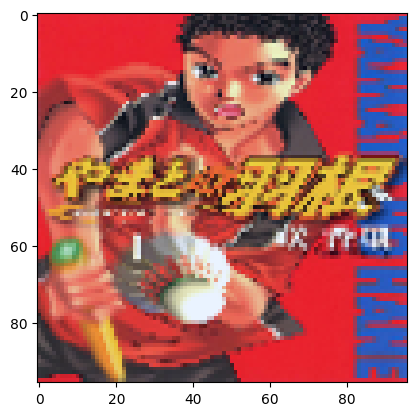

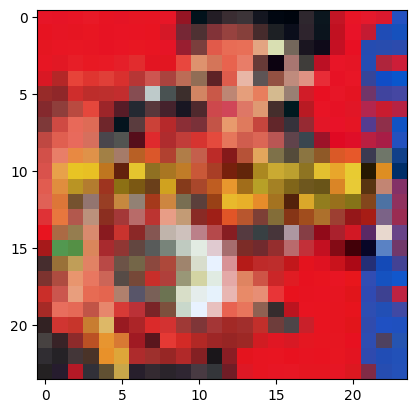

In [21]:
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

for data in dataloader:
    hr_img = data['hr']
    lr_img = data['lr']
    plt.imshow(normalize(hr_img[0].permute(1, 2, 0)))
    plt.figure()
    plt.imshow(normalize(lr_img[0].permute(1, 2, 0)))
    break

# Model

![Image Title](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-19_at_11.13.45_AM_zsF2pa7.png)

In [22]:
import torch
from torch import nn


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation_func=None, normalize=True, bias=True, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels, out_channels, bias=bias, **kwargs)
        self.batchNorm = nn.BatchNorm2d(out_channels) if normalize else nn.Identity()
        self.activation_func = activation_func
        

    def forward(self, x):
        out = self.cnn(x)
        out = self.batchNorm(out)
        if self.activation_func is not None:
            out = self.activation_func(out)
        return out


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # self.activation_func = nn.PReLU(num_parameters=in_channels)
        # first three layer of the residual block
        self.block_with_act = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1, activation_func=nn.PReLU(num_parameters=in_channels))
        # later 2 layer of the residual block
        self.block_wo_act = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = self.block_with_act(x)
        out = self.block_wo_act(out)
        return out + x


class PixelShufflerBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        out_channels = in_channels * scale_factor ** 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1) # in_c * 4, H, W --> in_c, H*2, W*2
        self.bn = nn.BatchNorm2d(out_channels)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.activation_function = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        out = self.conv(x)
        out = self.pixel_shuffle(out)
        out = self.activation_function(out)
        return out


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_res_blocks=16, num_pix_shuffle_blocks=2):
        super().__init__()
        self.first_layer = ConvBlock(in_channels, num_channels, activation_func=nn.PReLU(num_parameters=num_channels), kernel_size=9, stride=1, padding=4, normalize=False)
        self.residual_layer = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_res_blocks)])
        self.conv_layer = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle_layer = nn.Sequential(*[PixelShufflerBlock(num_channels, scale_factor=2) for _ in range(num_pix_shuffle_blocks)])
        self.output_layer = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.first_layer(x)
        out = self.residual_layer(initial)
        out = self.conv_layer(out) + initial
        out = self.pixel_shuffle_layer(out)
        out = self.output_layer(out)
        out = torch.tanh(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        activation_func = nn.LeakyReLU(0.2)
        self.layers = nn.Sequential(*[
            ConvBlock(in_channels, 64,  activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=False),
            ConvBlock(64,  64,  activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(64,  128, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(128, 128, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(128, 256, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(256, 256, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(256, 512, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(512, 512, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True)
        ])

        self.conv_out = nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1) # The output is a feature map. We're using patch GAN here.

    def forward(self, x):
        
        out = self.layers(x)

        out = self.conv_out(out)
        
        return out


def test():
    x = torch.randn((5, 3, LOW_RES, LOW_RES))
    gen = Generator()
    gen_out = gen(x)
    # print(gen)
    print(gen_out.shape)
    disc = Discriminator()
    # print(disc)
    disc_out = disc(gen_out)
    print(disc_out.shape)


test()

torch.Size([5, 3, 96, 96])
torch.Size([5, 1, 6, 6])


In [23]:
from torchsummary import summary
print(Generator())
summary(Generator(), (3, 24, 24))

Generator(
  (first_layer): ConvBlock(
    (cnn): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (batchNorm): Identity()
    (activation_func): PReLU(num_parameters=64)
  )
  (residual_layer): Sequential(
    (0): ResidualBlock(
      (block_with_act): ConvBlock(
        (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_func): PReLU(num_parameters=64)
      )
      (block_wo_act): ConvBlock(
        (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (block_with_act): ConvBlock(
        (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [24]:
print(Discriminator())
summary(Discriminator(), (3, 96, 96))

Discriminator(
  (layers): Sequential(
    (0): ConvBlock(
      (cnn): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchNorm): Identity()
      (activation_func): LeakyReLU(negative_slope=0.2)
    )
    (1): ConvBlock(
      (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_func): LeakyReLU(negative_slope=0.2)
    )
    (2): ConvBlock(
      (cnn): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchNorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_func): LeakyReLU(negative_slope=0.2)
    )
    (3): ConvBlock(
      (cnn): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (batchNorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_func): LeakyReLU(negative_slope=0

# VGG Loss

In [68]:
import torch.nn as nn
from torchvision.models import vgg19, VGG19_Weights

class TotalVariationLoss(nn.Module):
    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size(2)
        w_x = x.size(3)
        count_h = x[:, :, 1:, :].numel() / batch_size
        count_w = x[:, :, :, 1:].numel() / batch_size
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return 2 * (h_tv / count_h + w_tv / count_w) / batch_size


class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = nn.Sequential(*list(vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features.children())[:31]).eval().to(DEVICE)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False
            
    def forward(self, preds, target):
        vgg_input_features = self.vgg(preds)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)

In [69]:
VGGLoss()

VGGLoss(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

# Utils Functions

In [70]:
import torch
import os
import numpy as np
from PIL import Image
from torchvision.utils import save_image


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print(f"=> Saving checkpoint {filename}")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    if os.path.exists(checkpoint_file):
        print("=> Loading checkpoint")
        checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])

        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
    else:
        print("File does not exist.")
    
    return model, optimizer


# Training Evaluations

In [71]:
def generated_output(G, image):
    ts = transforms.Compose([
            transforms.Resize((24, 24), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    
    upscaled_img = ts(image).unsqueeze(0).to(DEVICE)
    gen_output = G(upscaled_img)
    gen_output = (gen_output.squeeze().permute(1, 2, 0).cpu().detach().numpy() + 1) * 0.5
    return upscaled_img, gen_output
    

def plot_examples(data_path, G):
    
    lr_files = os.listdir(data_path + "/LR/")
    hr_files = os.listdir(data_path + "/HR/")
    
    G.eval()
    for i in range(1):
        plt.figure(figsize=(15, 4))
        
        plt.subplot(1, 4, 1)
        image = Image.open(os.path.join(data_path + "/LR/", lr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Low-Resolution Image')

        transformed_lr, generated_img = generated_output(G, image)
        transformed_lr = (transformed_lr - transformed_lr.min()) / (transformed_lr.max() - transformed_lr.min())
        
        plt.subplot(1, 4, 2)
        plt.imshow(transformed_lr.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title('Transformed Image')
        
        plt.subplot(1, 4, 3)
        plt.imshow(generated_img)
        plt.axis('off')
        plt.title('Generated Image')
        
        plt.subplot(1, 4, 4)
        image = Image.open(os.path.join(data_path + "/HR/", hr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('High-Resolution Image')
        
        plt.tight_layout()
        plt.show()       
        

# Training Model

In [74]:
import torch
# import config
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm

torch.backends.cudnn.benchmark = True


def train_epoch(loader, D, G, opt_gen, opt_disc, mse_loss, gan_loss_func, vgg_loss_fun, tv_loss_func):
    
    training_metric = {"g_loss": [], "d_loss": [], "percp_loss": [], "l2_loss": [], "tv_loss": []}

    D.train()
    G.train()
    for i, imgs in enumerate(loader):
        low_res = imgs['lr'].to(DEVICE)
        high_res = imgs['hr'].to(DEVICE)

        # Train Generator

        opt_gen.zero_grad()
        gen_high_res = G(low_res)
        disc_out = D(gen_high_res)

        g_adv_loss = gan_loss_func(disc_out, torch.ones_like(disc_out))
        percp_loss = vgg_loss_fun(gen_high_res, high_res)
        l2_loss = mse_loss(gen_high_res, high_res)
        tv_loss = tv_loss_func(gen_high_res)

        g_loss = l2_loss + 1e-3 * g_adv_loss + 6e-3 * percp_loss + 2e-8 * tv_loss

        g_loss.backward()
        opt_gen.step()

        # Train Discriminator

        opt_disc.zero_grad()
        disc_out_real = D(high_res)
        loss_real = mse_loss(disc_out_real, torch.ones_like(disc_out_real))

        disc_out_fake = D(gen_high_res.detach())
        loss_fake = mse_loss(disc_out_fake, torch.zeros_like(disc_out_fake))

        d_loss = (loss_real + loss_fake)

        d_loss.backward()
        opt_disc.step()

        
        if i % 10 == 9:
            print(f"\tg_loss: {g_loss.item()}, percp_loss: {percp_loss.item()}, l2_loss: {l2_loss.item()}, d_loss: {d_loss.item()}")
            training_metric["g_loss"].append(g_loss.item())
            training_metric["d_loss"].append(d_loss.item())
            training_metric["percp_loss"].append(percp_loss.item())
            training_metric["l2_loss"].append(l2_loss.item())
            training_metric["tv_loss"].append(tv_loss.item())

    return training_metric, D, G, opt_gen, opt_disc 

	g_loss: 1.2918033599853516, percp_loss: 51.08332443237305, l2_loss: 0.9847042560577393, d_loss: 0.3932117819786072
	g_loss: 1.173674464225769, percp_loss: 55.78816604614258, l2_loss: 0.8382739424705505, d_loss: 0.18625356256961823
	g_loss: 1.140836477279663, percp_loss: 59.16080856323242, l2_loss: 0.7851452827453613, d_loss: 0.14910945296287537
epoch = 0 {'g_loss': 1.2021047671635945, 'd_loss': 0.2428582658370336, 'percp_loss': 55.34409968058268, 'l2_loss': 0.8693744937578837, 'tv_loss': 0.04453595355153084}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


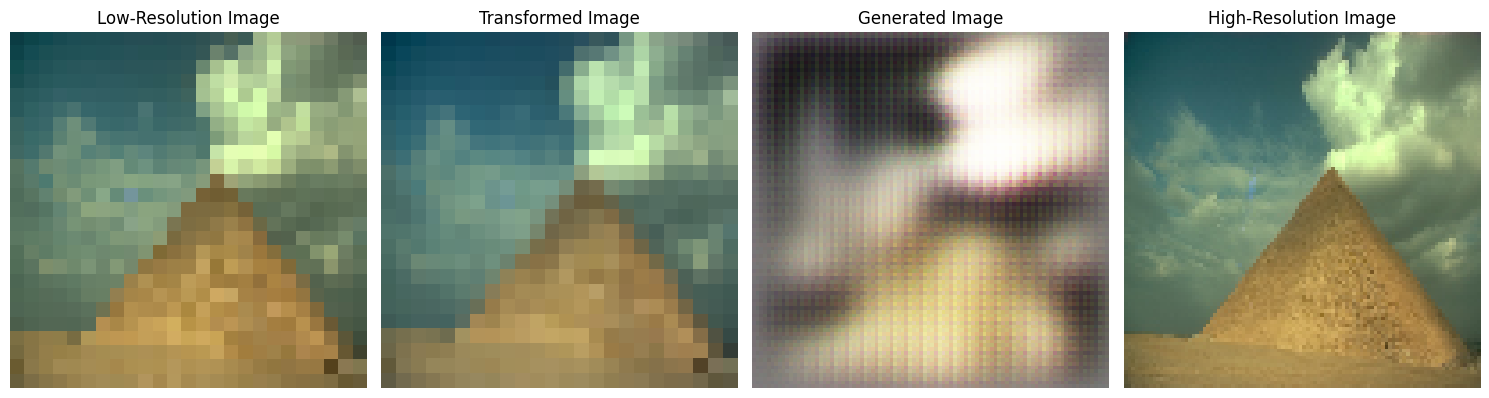

	g_loss: 1.0784131288528442, percp_loss: 44.47584915161133, l2_loss: 0.8109140992164612, d_loss: 0.07641838490962982
	g_loss: 0.8011945486068726, percp_loss: 43.00093078613281, l2_loss: 0.5426307916641235, d_loss: 0.1629425436258316
	g_loss: 0.7827224731445312, percp_loss: 42.507415771484375, l2_loss: 0.527084469795227, d_loss: 0.1469791829586029
epoch = 1 {'g_loss': 0.8874433835347494, 'd_loss': 0.1287800371646881, 'percp_loss': 43.32806523640951, 'l2_loss': 0.6268764535586039, 'tv_loss': 0.053022327522436775}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


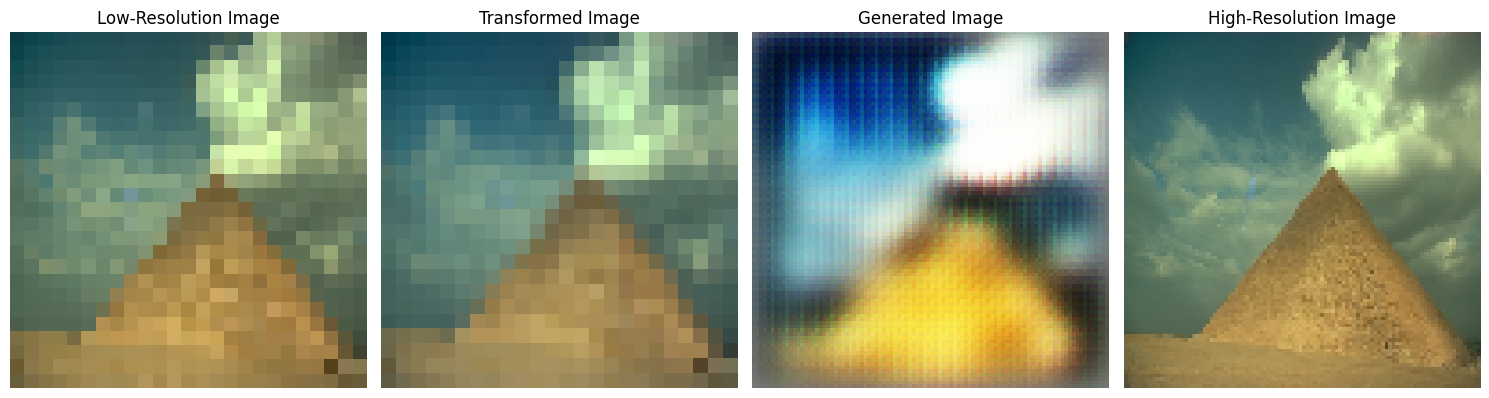

	g_loss: 0.8941854238510132, percp_loss: 65.24259185791016, l2_loss: 0.5020335912704468, d_loss: 0.10951051115989685
	g_loss: 0.6697133183479309, percp_loss: 40.53797149658203, l2_loss: 0.42583444714546204, d_loss: 0.04957471787929535
	g_loss: 0.9576519727706909, percp_loss: 51.57198715209961, l2_loss: 0.647511899471283, d_loss: 0.03181680664420128
epoch = 2 {'g_loss': 0.8405169049898783, 'd_loss': 0.06363401189446449, 'percp_loss': 52.45085016886393, 'l2_loss': 0.5251266459623972, 'tv_loss': 0.058896647145350776}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


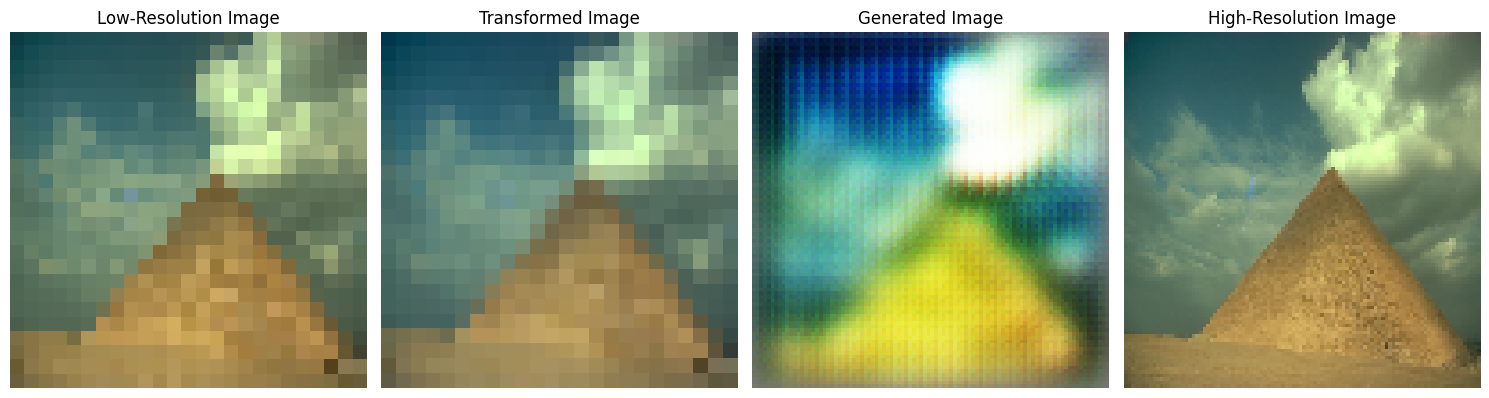

	g_loss: 0.9040130972862244, percp_loss: 57.82918167114258, l2_loss: 0.556372880935669, d_loss: 0.028600450605154037
	g_loss: 0.7988337874412537, percp_loss: 39.31218719482422, l2_loss: 0.5622426271438599, d_loss: 0.04514925926923752
	g_loss: 0.9038375616073608, percp_loss: 53.01368713378906, l2_loss: 0.5851086378097534, d_loss: 0.03434057533740997
epoch = 3 {'g_loss': 0.8688948154449463, 'd_loss': 0.03603009507060051, 'percp_loss': 50.05168533325195, 'l2_loss': 0.5679080486297607, 'tv_loss': 0.06201890856027603}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


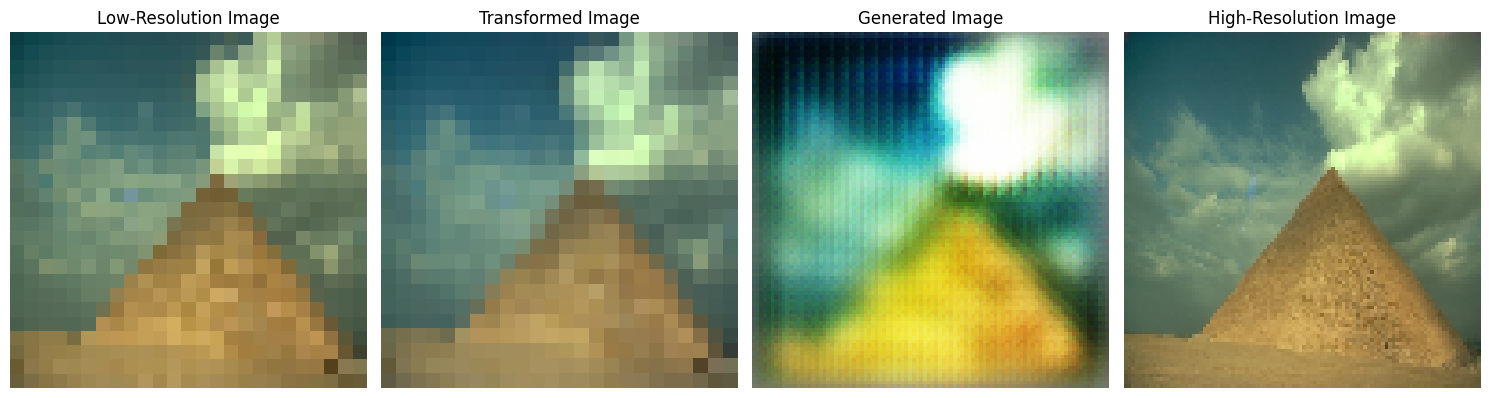

	g_loss: 0.8367067575454712, percp_loss: 64.25100708007812, l2_loss: 0.4505520462989807, d_loss: 0.030173446983098984
	g_loss: 0.7182045578956604, percp_loss: 39.38045883178711, l2_loss: 0.48128241300582886, d_loss: 0.05325956642627716
	g_loss: 0.728188157081604, percp_loss: 35.74185562133789, l2_loss: 0.5130575895309448, d_loss: 0.020610369741916656
epoch = 4 {'g_loss': 0.7610331575075785, 'd_loss': 0.0346811277170976, 'percp_loss': 46.45777384440104, 'l2_loss': 0.48163068294525146, 'tv_loss': 0.07003215452035268}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


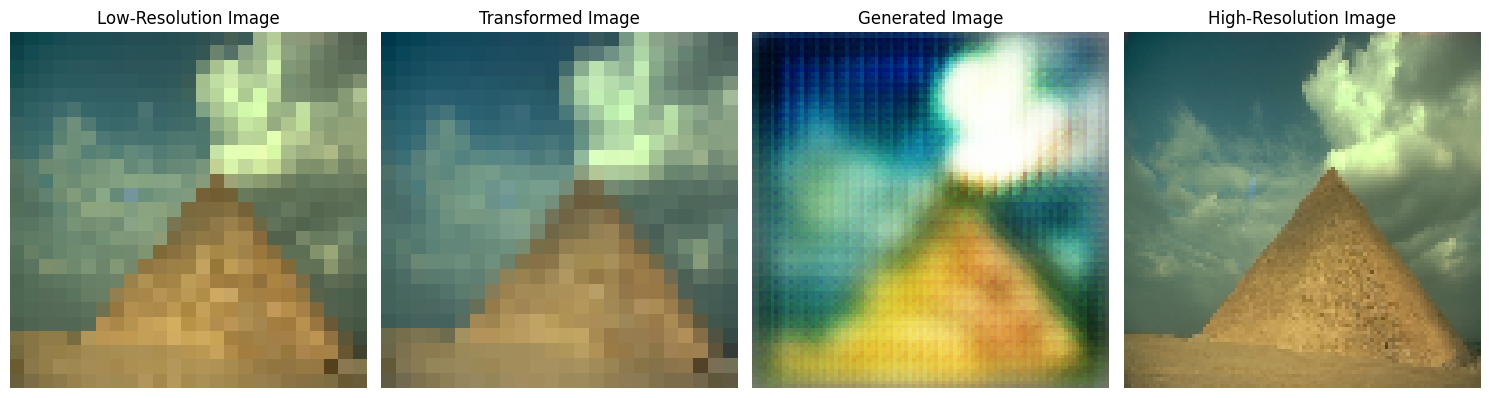

	g_loss: 0.5997697114944458, percp_loss: 35.26374435424805, l2_loss: 0.3875201642513275, d_loss: 0.019832555204629898
	g_loss: 0.7000789642333984, percp_loss: 47.63763427734375, l2_loss: 0.41362056136131287, d_loss: 0.035023391246795654
	g_loss: 0.7749831676483154, percp_loss: 37.38106155395508, l2_loss: 0.5499598383903503, d_loss: 0.030751528218388557
epoch = 5 {'g_loss': 0.6916106144587199, 'd_loss': 0.028535824889938038, 'percp_loss': 40.094146728515625, 'l2_loss': 0.4503668546676636, 'tv_loss': 0.06888912866512935}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


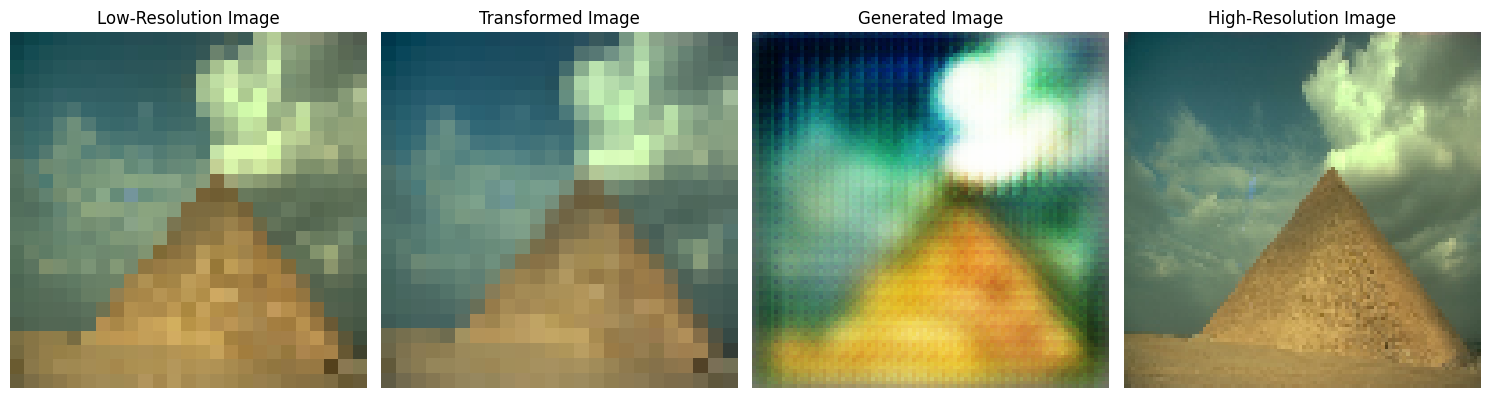

	g_loss: 0.8573854565620422, percp_loss: 45.014442443847656, l2_loss: 0.5866243243217468, d_loss: 0.03179597482085228
	g_loss: 0.8560224771499634, percp_loss: 43.0596923828125, l2_loss: 0.5969773530960083, d_loss: 0.024885162711143494
	g_loss: 0.7379223108291626, percp_loss: 34.52357482910156, l2_loss: 0.5301358103752136, d_loss: 0.037092626094818115
epoch = 6 {'g_loss': 0.8171100815137228, 'd_loss': 0.031257921208937965, 'percp_loss': 40.86590321858724, 'l2_loss': 0.5712458292643229, 'tv_loss': 0.07364791631698608}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


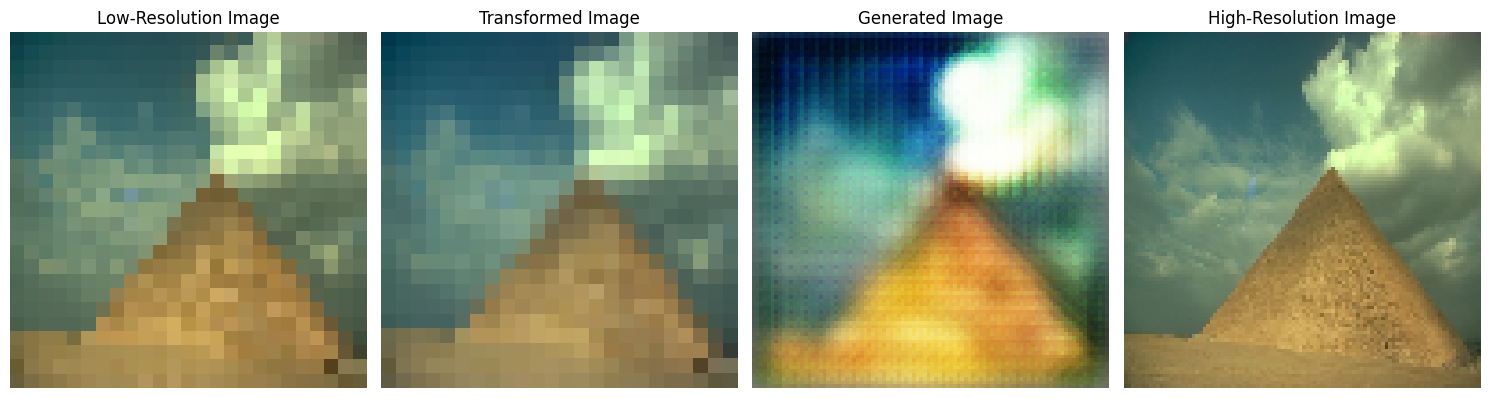

	g_loss: 0.678532600402832, percp_loss: 30.144914627075195, l2_loss: 0.4969661235809326, d_loss: 0.01882031373679638
	g_loss: 0.7179303169250488, percp_loss: 36.65550994873047, l2_loss: 0.4972991943359375, d_loss: 0.009794039651751518
	g_loss: 0.8132901191711426, percp_loss: 38.88437271118164, l2_loss: 0.5792816281318665, d_loss: 0.01275690272450447
epoch = 7 {'g_loss': 0.7365843454996744, 'd_loss': 0.01379041870435079, 'percp_loss': 35.2282657623291, 'l2_loss': 0.5245156486829122, 'tv_loss': 0.0753549908598264}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


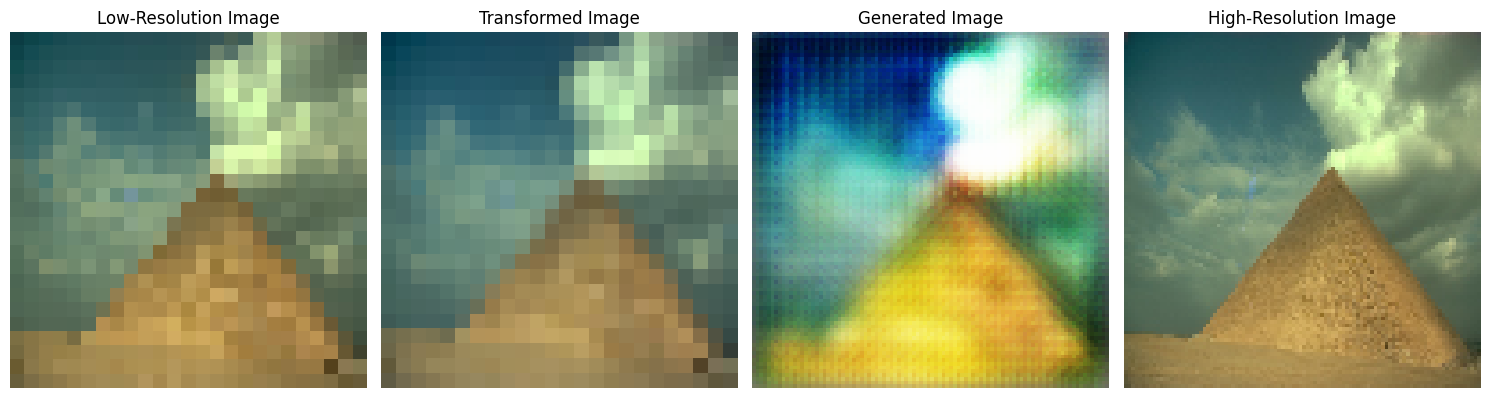

	g_loss: 0.7669837474822998, percp_loss: 38.74769973754883, l2_loss: 0.5337899923324585, d_loss: 0.008456113748252392
	g_loss: 0.5857752561569214, percp_loss: 34.62350845336914, l2_loss: 0.3773397207260132, d_loss: 0.00773649662733078
	g_loss: 0.8145269155502319, percp_loss: 39.18656539916992, l2_loss: 0.57872074842453, d_loss: 0.008027100004255772
epoch = 8 {'g_loss': 0.7224286397298177, 'd_loss': 0.008073236793279648, 'percp_loss': 37.51925786336263, 'l2_loss': 0.4966168204943339, 'tv_loss': 0.07984127352635066}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


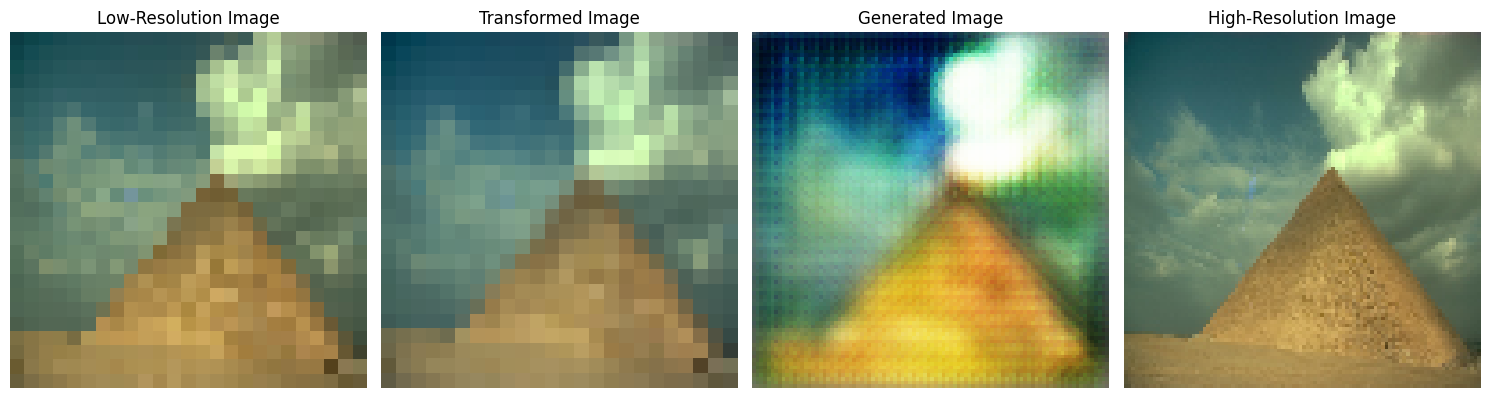

	g_loss: 0.5839567184448242, percp_loss: 31.207204818725586, l2_loss: 0.39604413509368896, d_loss: 0.011712955310940742
	g_loss: 0.8308811187744141, percp_loss: 53.209716796875, l2_loss: 0.5109503865242004, d_loss: 0.007505510933697224
	g_loss: 0.7403691411018372, percp_loss: 35.21175003051758, l2_loss: 0.5284096002578735, d_loss: 0.006657263729721308
epoch = 9 {'g_loss': 0.7184023261070251, 'd_loss': 0.008625243324786425, 'percp_loss': 39.87622388203939, 'l2_loss': 0.47846804062525433, 'tv_loss': 0.09011702239513397}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


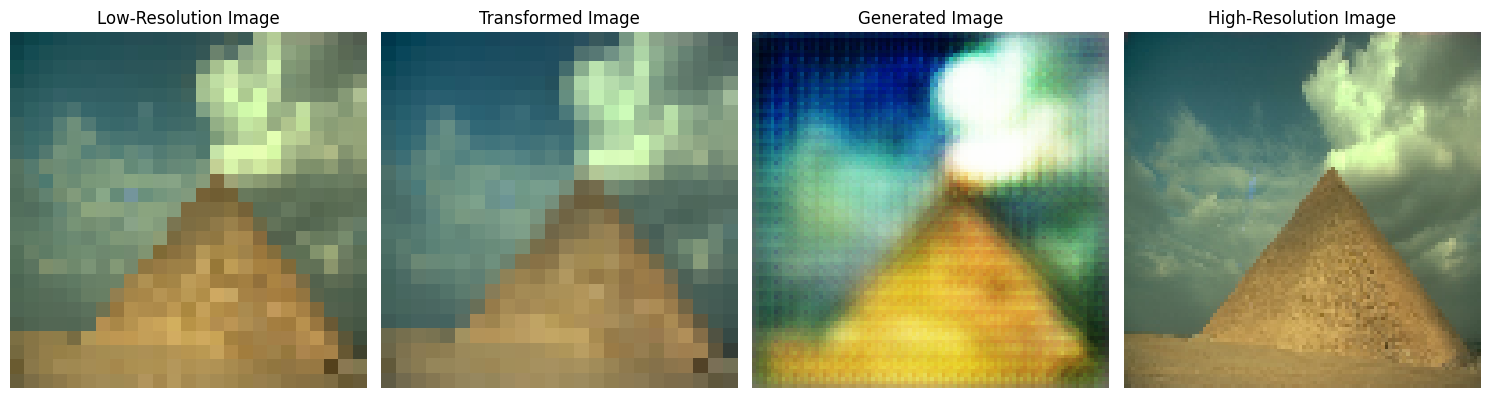

In [75]:
G = Generator().to(DEVICE)
G_optimizer = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))

D = Discriminator().to(DEVICE)
D_optimizer = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))


if False:
    load_checkpoint(CHECKPOINT_GEN, G, G_optimizer, LEARNING_RATE)
    load_checkpoint(CHECKPOINT_DISC, D, D_optimizer, LEARNING_RATE)
    print("Loaded Model Successfully")

training_metric = {"g_loss": [], "d_loss": [], "percp_loss": [], "l2_loss": [], "tv_loss": []}

for epoch in range(10):
    epoch_metric, D, G, G_optimizer, D_optimizer = train_epoch(dataloader, D, G, G_optimizer, D_optimizer, 
                                                               nn.MSELoss(), nn.BCEWithLogitsLoss(), VGGLoss(), TotalVariationLoss())

    for key in epoch_metric.keys():
        training_metric[key].append(np.mean(epoch_metric[key]))
    print(f"{epoch = }", {k: training_metric[k][-1] for k in training_metric.keys()})

    if SAVE_MODEL:
        save_checkpoint(G, G_optimizer, filename=CHECKPOINT_GEN)
        save_checkpoint(D, D_optimizer, filename=CHECKPOINT_DISC)
    
    plot_examples(base_data_path, G)
    # if epoch % 10 == 9:
    #     plot_examples(base_data_path, G)

# Model Evaluation

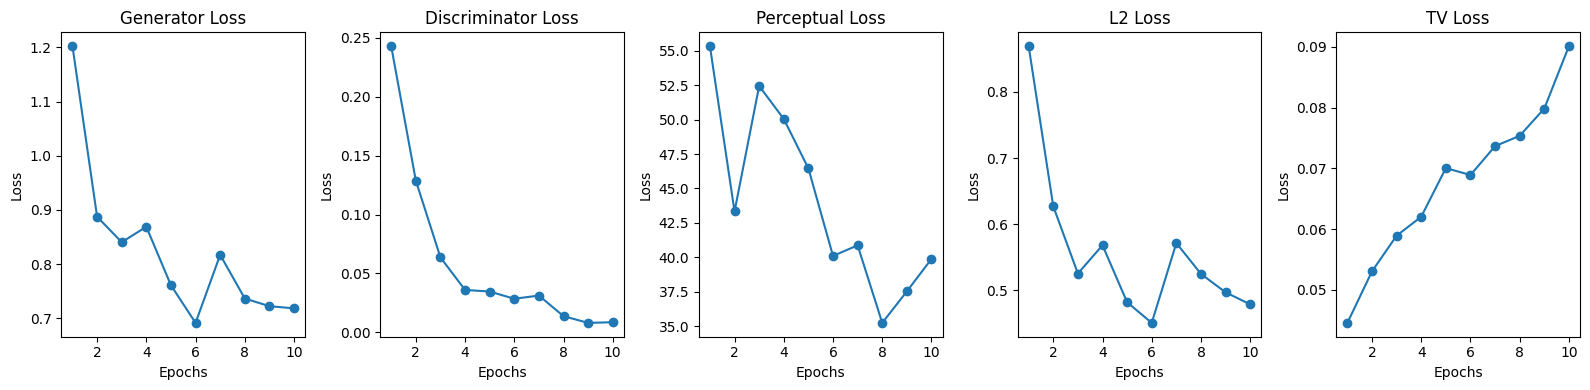

In [77]:
def plot_training_metrics(training_metric):
    num_epochs = len(training_metric['g_loss'])
    epochs = np.arange(1, num_epochs + 1)  # Assuming start from 1, adjust if needed

    # Plotting side by side without epoch axis
    fig, axs = plt.subplots(1, 5, figsize=(16, 4))

    # Plot g_loss
    axs[0].plot(epochs, training_metric['g_loss'], marker='o')
    axs[0].set_title('Generator Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

    # Plot d_loss
    axs[1].plot(epochs, training_metric['d_loss'], marker='o')
    axs[1].set_title('Discriminator Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')

    # Plot vgg_loss
    axs[2].plot(epochs, training_metric['percp_loss'], marker='o')
    axs[2].set_title('Perceptual Loss')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Loss')

    # Plot l2_loss
    axs[3].plot(epochs, training_metric['l2_loss'], marker='o')
    axs[3].set_title('L2 Loss')
    axs[3].set_xlabel('Epochs')
    axs[3].set_ylabel('Loss')

    axs[4].plot(epochs, training_metric['tv_loss'], marker='o')
    axs[4].set_title('TV Loss')
    axs[4].set_xlabel('Epochs')
    axs[4].set_ylabel('Loss')

    plt.tight_layout()
    plt.show()
    
plot_training_metrics(training_metric)

In [ ]:
print("Showing Sample images generated by the model")
plot_examples(base_data_path, G)